# Efficient Portfolios
*Created 10/06/2021*

This quick notebook builds efficient portfolios and evaluates hedging strategies using equity and futures data.

**Topics covered:** shrinkage covariance estimation, correlated return simulation, Sharpe-optimal portfolio optimization, variance-minimizing futures hedging, $R^2$ $hedge effectiveness tests, and beta-based return simulation.

In [557]:
# imports
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels import regression
from sklearn.covariance import LedoitWolf

**Pulling Data From Yahoo Finance**

In [558]:
now = dt.datetime.now()
start = now - dt.timedelta(days=365)

stocks = ['AAPL', 'TSLA', 'NFLX', 'XOM', 'T']

df = yf.download(stocks, start=start, end=now, group_by='ticker', auto_adjust=True)

adj_close = df.xs('Close', axis=1, level='Price')
adj_close.head()


[*********************100%***********************]  5 of 5 completed


Ticker,NFLX,TSLA,AAPL,T,XOM
Date,,,,,
2024-12-11,93.655998,424.769989,245.380219,22.473278,107.957809
2024-12-12,92.555000,418.100006,246.843582,22.358425,107.861336
2024-12-13,91.887001,436.230011,247.012833,22.616848,106.916039
2024-12-16,92.108002,463.019989,249.909698,21.860720,104.629951
2024-12-17,91.913002,479.859985,252.338730,21.851149,104.186234


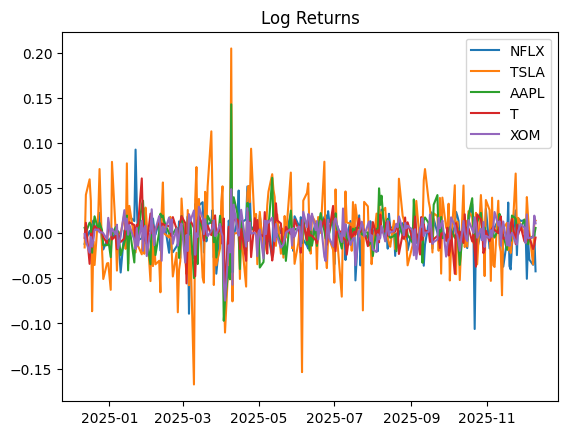

Ticker
NFLX   -0.010234
TSLA    0.061406
AAPL    0.128639
T       0.082504
XOM     0.102729
dtype: float64

In [559]:

log_returns = np.log(adj_close / adj_close.shift(1))
log_returns.dropna(inplace=True)

plt.plot(log_returns)
plt.title('Log Returns')
plt.legend(log_returns.columns)
plt.show()

annualized_mean_return = log_returns.mean() * 251
annualized_mean_return

**Covariance (using Ledoit–Wolf shrinkage) / correlation matrices**

Ledoit–Wolf shrinkage replaces the sample covariance matrix $S$ with a convex combination $\Sigma_{LW} = \delta*F + (1-\delta)S$ where $F$ is usually the average variance matrix and $\delta$ is an optimally chosen shrinkage intensity that minimizes MSE,

In [560]:
# covariance matrix
lw = LedoitWolf().fit(log_returns)
annual_cov_data = lw.covariance_ * 251
print("Shrinkage covariance matrix:\n", annual_cov_data)

# correlation matrix
corr_matrix = log_returns.corr()
print("Correlation matrix:\n", corr_matrix)

Shrinkage covariance matrix:
 [[ 0.11965012  0.06396075  0.0349081   0.01184687  0.00703688]
 [ 0.06396075  0.39649972  0.10150855 -0.00888551  0.03045769]
 [ 0.0349081   0.10150855  0.10770583  0.01116019  0.02711961]
 [ 0.01184687 -0.00888551  0.01116019  0.05773202  0.0079645 ]
 [ 0.00703688  0.03045769  0.02711961  0.0079645   0.06153656]]
Correlation matrix:
 Ticker      NFLX      TSLA      AAPL         T       XOM
Ticker                                                  
NFLX    1.000000  0.312374  0.340278  0.166047  0.094851
TSLA    0.312374  1.000000  0.525451 -0.066135  0.218012
AAPL    0.340278  0.525451  1.000000  0.165794  0.387448
T       0.166047 -0.066135  0.165794  1.000000  0.163610
XOM     0.094851  0.218012  0.387448  0.163610  1.000000


### Example portfolio generation

We generate a random portfolio by sampling weights that sum to one. The expected portfolio return is computed as the weighted sum of individual asset returns, $$R_p = \sum_{i=1}^{n} w_i \, \mu_i,$$
where $w_i$ = portfolio weight of asset, $\mu_i$ = expected (annualized) return of asset. 

Portfolio volatility is computed using the standard quadratic form, $$\sigma_p = \sqrt{ \mathbf{w}^\top \Sigma \mathbf{w} },$$
where $w$ = vector of portfolio weights and $\Sigma$ = covariance matrix of asset returns.

The Sharpe ratio is used for risk-adjusted performance comparisons. Assuming no risk-free rate, $$\text{Sharpe Ratio} = \frac{R_p}{\sigma_p}.$$ 

In [561]:
class SamplePortfolio:     
    def generate_characteristics(self):
        weight = np.random.random(len(stocks))
        self.weights = (weight / np.sum(weight))
        self.returns = np.dot(self.weights, self.return_data)
        self.volatility = np.sqrt(np.dot(self.weights, np.dot(self.cov_data, self.weights)))
        self.SharpeRatio = self.returns/self.volatility
    
    
    def __init__(self, return_data, cov_data):
        self.return_data = return_data
        self.cov_data = cov_data

sample_portfolio = SamplePortfolio(annualized_mean_return, annual_cov_data)
sample_portfolio.generate_characteristics()

print(f"Weights: {sample_portfolio.weights}\nVolatility: {sample_portfolio.volatility}\nReturn: {sample_portfolio.returns}\nSharpe ratio: {sample_portfolio.SharpeRatio}")
        

Weights: [0.28062822 0.0202029  0.21858218 0.27882734 0.20175936]
Volatility: 0.18728488885271038
Return: 0.07021774622304083
Sharpe ratio: 0.3749247825235028


### Optimization

We will use mean-variance optimization to calculate and plot the efficient frontier. 


#### Monte Carlo simulation

In [562]:
class PortfolioGenerator:
    def __init__(self, return_data, cov_data):
        w = np.random.random(len(stocks))
        self.weights = w / np.sum(w)
        self.returns = np.dot(self.weights, return_data)
        self.volatility = np.sqrt(np.dot(self.weights, np.dot(cov_data, self.weights)))
        self.SharpeRatio = self.returns / self.volatility   # (risk-free rate = 0)


n_sim = 50000

weights = []
returns = []
vol = []
SharpeRatio = []

for i in range(n_sim):
    portfolio = PortfolioGenerator(annualized_mean_return, annual_cov_data)
    weights.append(portfolio.weights)
    returns.append(portfolio.returns)
    vol.append(portfolio.volatility)
    SharpeRatio.append(portfolio.SharpeRatio)

portfolio_data = {
    'Returns': returns,
    'Volatility': vol,
    'Sharpe Ratio': SharpeRatio
}

for i, t in enumerate(stocks):
    portfolio_data[f'{t} weight'] = [w[i] for w in weights]

df = pd.DataFrame(portfolio_data)
print(df.head())


    Returns  Volatility  Sharpe Ratio  AAPL weight  TSLA weight  NFLX weight  \
0  0.051224    0.224537      0.228133     0.355110     0.183471     0.045045   
1  0.088669    0.266627      0.332558     0.102068     0.237222     0.292746   
2  0.061242    0.257167      0.238143     0.264337     0.261831     0.164052   
3  0.106388    0.225956      0.470835     0.014495     0.075996     0.491708   
4  0.081863    0.293886      0.278555     0.084124     0.334422     0.302758   

   XOM weight  T weight  
0    0.246032  0.170342  
1    0.015454  0.352509  
2    0.250046  0.059734  
3    0.212770  0.205031  
4    0.266387  0.012309  


#### Scatter plot

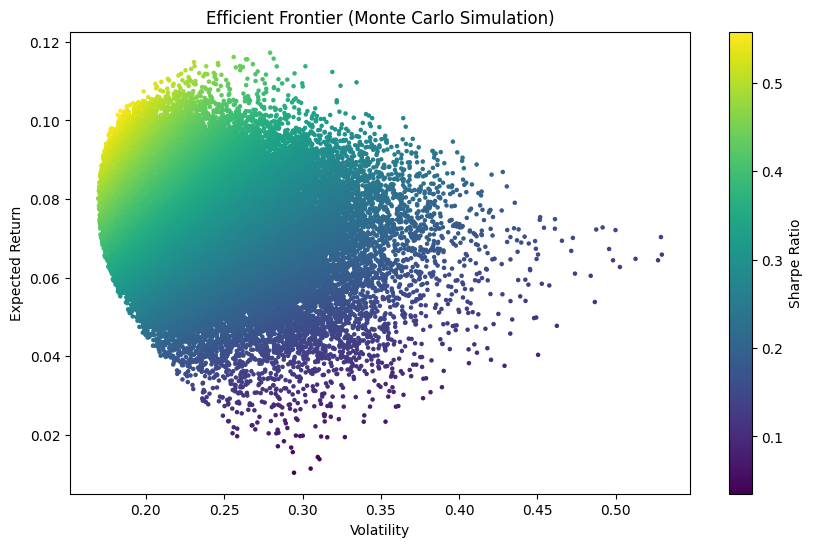

In [563]:
plt.figure(figsize=(10,6))
plt.scatter(df['Volatility'], df['Returns'], c=df['Sharpe Ratio'], cmap='viridis', s=5)
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier (Monte Carlo Simulation)')
plt.colorbar(label='Sharpe Ratio')
plt.show()

#### Maximum Sharpe Rate Protfolio

We choose portfolio weights $w$ to maximize the Sharpe ratio,

$$\max_{w} \; \frac{w^\top \mu}{\sqrt{w^\top \Sigma w}},$$

where $\mu$ is the expected return vector and $\Sigma$ is the return covariance matrix.

Since the denominator is strictly positive, this is equivalent to

$$\min_{w} \; -\frac{w^\top \mu}{\sqrt{w^\top \Sigma w}}.$$

The optimizer simply minimizes neg_sharpe_ratio() under the weight constraints.

In [564]:
## simple approximation --> doesn't solve the true analytical optimum
# optimal = df.loc[df['Sharpe Ratio'].idxmax()]
# print(optimal)

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def neg_sharpe_ratio(weights, mean_returns, cov_matrix):            # (we are minimizing)
    ret = portfolio_return(weights, mean_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    return -ret / vol

# weights must sum to 1 and all weights must be >= 0 (long only portfolio)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in stocks)

num_assets = len(stocks)
initial_guess = num_assets * [1.0 / num_assets]   # equal weights start

optimal_solution = minimize(
    neg_sharpe_ratio,
    initial_guess,
    args=(annualized_mean_return, annual_cov_data),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights = optimal_solution.x
optimal_return = portfolio_return(optimal_weights, annualized_mean_return)
optimal_volatility = portfolio_volatility(optimal_weights, annual_cov_data)
optimal_sharpe = optimal_return / optimal_volatility

print("Optimal weights:")
for asset, weight in zip(stocks, optimal_weights):
    print(f"{asset}: {weight:.4f}")
print(f"\nOptimal portfolio return: {optimal_return:.4f}")
print(f"Optimal portfolio volatility: {optimal_volatility:.4f}")
print(f"Optimal Sharpe ratio: {optimal_sharpe:.4f}")


Optimal weights:
AAPL: 0.0000
TSLA: 0.0000
NFLX: 0.2543
XOM: 0.3627
T: 0.3830

Optimal portfolio return: 0.1020
Optimal portfolio volatility: 0.1820
Optimal Sharpe ratio: 0.5602


**Explanation**
* NFLX's contribution is higher because its recent 1 year returns were stable compared to TSLA/AAPL. 
* XOM is energy/oil so its price behavior is driven partly by commodity markets rather than just SPY (the correlation matrix confirms this).
* AT&T usually has low variance, lower beta, and stable returns so it reduces overall portfolio volatility (boosts th Sharpe ratio).

The optimal Sharpe is realistic for 1 year equities.

### Value at risk (VaR)

#### Parametric and Monte Carlo simulation

* using 99% confidence interval and normal return assumptions


In [565]:
# parametric

conf_lvl = 0.99
v_0 = 1_000_000 
days_to_project = 1

Optimal_Return = optimal_return
optimal_val_exposure = optimal_volatility    # annualized volatility

daily_vol = optimal_val_exposure / np.sqrt(251)

print(f"Portfolio volatility (daily): {round(daily_vol * 100, 2)}%")
print(f"Portfolio volatility (annualized): {round(optimal_val_exposure * 100, 2)}%")

deg_cert = norm.ppf(conf_lvl)

VaR = v_0 * deg_cert * daily_vol

print(f"{conf_lvl * 100}% 1 day VaR: ${round(VaR, 2)}")


Portfolio volatility (daily): 1.15%
Portfolio volatility (annualized): 18.2%
99.0% 1 day VaR: $26731.29


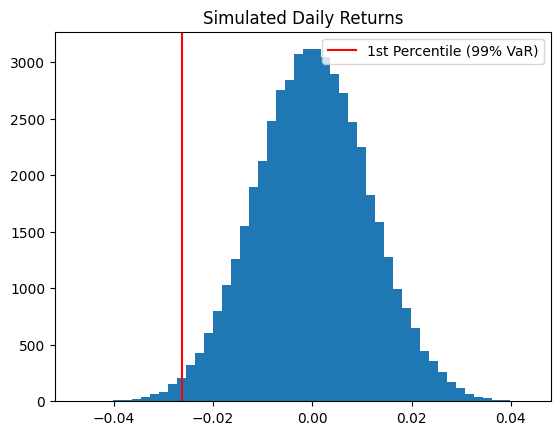

Simulation VaR = $26180.13 (compare to parametric VaR of $26731.29)


In [566]:
# simulation

daily_vol = optimal_volatility / np.sqrt(251)
tsim = []

for i in range(50000):
    tsim.append(np.random.normal(0, daily_vol))

tsim = np.array(tsim)

first_percentile = np.percentile(tsim, 1)

# VaR is the absolute loss
VaR2 = abs(v_0 * first_percentile)

plt.hist(tsim, bins=50)
plt.title("Simulated Daily Returns")
plt.axvline(x=first_percentile, label='1st Percentile (99% VaR)', color="red")
plt.legend()
plt.show()

print(f"Simulation VaR = ${round(VaR2, 2)} (compare to parametric VaR of ${round(VaR, 2)})")


#### EWMA Volatility (λ = 0.94)
RiskMetrics model:  ${\sigma}^2_t = (1 − λ){r^2}_{t−1} + λ{\sigma}^2_{t−1}$

In [567]:
lambda_ = 0.94
ewma_var = [log_returns.var().mean()]  # start value

for r in log_returns.mean(axis=1):
    ewma_var.append(lambda_ * ewma_var[-1] + (1 - lambda_) * r**2)

ewma_vol = np.sqrt(ewma_var[-1])
ewma_VaR = v_0 * norm.ppf(conf_lvl) * ewma_vol

print("EWMA daily volatility:", ewma_vol)
print("EWMA VaR (1 day, 99%):", ewma_VaR)

EWMA daily volatility: 0.009195678678589126
EWMA VaR (1 day, 99%): 21392.3475442985


#### Multivariate Normal Simulation of Portfolio Returns
Simulate correlated asset returns using Cholesky decomposition.

Below, we generate $$Z \sim \mathcal{N}(0, I)$$ and multiply by $L$ (the Cholesky factor). This produces simulated returns $R=LZ$ that has $\text{Cov}(R)=\Sigma$.

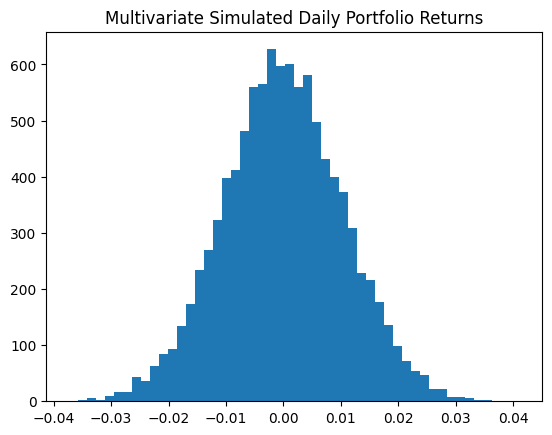

In [568]:
n_sim = 10000

chol = np.linalg.cholesky(annual_cov_data / 251)
simulated = np.random.normal(size=(n_sim, len(stocks))) @ chol

sim_port_returns = simulated @ optimal_weights

plt.hist(sim_port_returns, bins=50)
plt.title("Multivariate Simulated Daily Portfolio Returns")
plt.show()

#### Compute portfolio Beta using optimal weights

A portfolio beta greater than 1 indicates the portfolio amplifies market returns, while a beta below 1 indicates reduced sensitivity.

If we anticipate a market crash, we can hedge by taking a short futures position with beta = –1, meaning the hedge gains value when SPY falls.
Alternatively, if we expect certain constituents to be under stress, we can adjust our target beta to 1 (market-neutral) or another desired exposure level.

**Why not just sell our holdings?**

Selling the portfolio outright may be inefficient/costly, especially when the goal is temporary risk reduction.
Hedging with futures is cheaper and we can measure hedge effectiveness for accounting purposes.

In [569]:
start = dt.datetime(2019, 1, 1)
now = dt.datetime.now()

SPY_stocks = ['AAPL', 'TSLA', 'NFLX', 'XOM', 'T', 'SPY']

df = yf.download(SPY_stocks, start=start, end=now, group_by='ticker', auto_adjust=True)     # needed to default auto_adjust to True to silence warnings
close_prices = df.xs('Close', axis=1, level='Price')

LNRet = np.log(close_prices / close_prices.shift(1))
LNRet.dropna(inplace=True)

# regression function
def linreg(x, y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    return model.params.iloc[1]


# compute betas
SPY_returns = LNRet['SPY']
betas = []

for symbol in SPY_stocks:
    beta = linreg(SPY_returns, LNRet[symbol])
    betas.append(beta)

print("Betas with SPY:")
print(betas)

beta_without_SPY = betas[:-1]
print("Betas without SPY:")
print(beta_without_SPY)

[*********************100%***********************]  6 of 6 completed

Betas with SPY:
[np.float64(1.2207243749444794), np.float64(1.6875869261431007), np.float64(1.0400829855323916), np.float64(0.8152018662225711), np.float64(0.5541828837194943), np.float64(0.9999999999999994)]
Betas without SPY:
[np.float64(1.2207243749444794), np.float64(1.6875869261431007), np.float64(1.0400829855323916), np.float64(0.8152018662225711), np.float64(0.5541828837194943)]


Now that we have a portfolio beta, we can measure how sensitive our portfolio is to movements in the overall market.

In [570]:
# weights = []
# for i in range(3, 8):
#     weights.append(x[0][i])

# portfolio_beta = np.dot(weights, beta_without_SPY)
# print(portfolio_beta)

portfolio_beta = float(np.dot(optimal_weights, beta_without_SPY))
portfolio_beta = round(portfolio_beta, 4)
print("Portfolio Beta:", portfolio_beta)

Portfolio Beta: 0.7724


**Rolling 252 day beta**

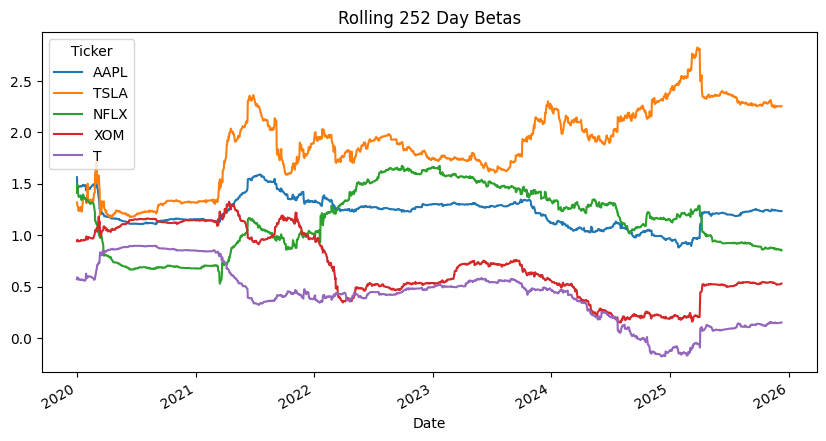

In [571]:
window = 252
rolling_beta = (
    LNRet[stocks].rolling(window).cov(LNRet['SPY'])
    .div(LNRet['SPY'].rolling(window).var(), axis=0)
)

rolling_beta.plot(figsize=(10,5))
plt.title("Rolling 252 Day Betas")
plt.show()

#### Hedging with E-Mini futures on the S&P 500

<a id="hedging"></a>

We have

$$N=(\beta_{\text{target}}−\beta_{\text{portfolio}})*\frac{V}{\text{Futures Value}}.$$

Setting `target = 1` will **add** to market risk.

For testing downside hedging, set either `target = 0` (market neutral) or `target = -1`  (crash hedging, what we use below). You will see $R^2$ drop. 


In [572]:
# get ES futures (E-mini S&P 500) price
es = yf.download('ES=F', period="5d", auto_adjust=True)
if es.empty:                                                # errors may pop up here because yahoo doesn't provide deep historical futures data
    raise ValueError("ES futures data not available.")      

futures = es['Close'].dropna().iloc[-1].item()
print("Futures price:", futures)

target = -1
print("Target Beta:", target)

class FuturesContract:
    def __init__(self, futures_price, multiplier):
        self.futures_price = float(futures_price)
        self.multiplier = float(multiplier)
        self.value = self.futures_price * self.multiplier

class HedgeBeta:
    def __init__(self, port_val, port_beta, target_beta, FuturesContract):
        self.port_val = float(port_val)
        self.port_beta = float(port_beta)
        self.target_beta = float(target_beta)
        self.hedge_val = float(FuturesContract.value)
        self.num_contracts = (self.target_beta-self.port_beta) * (self.port_val / self.hedge_val)

contract = FuturesContract(futures, 50)
sim_hedge = HedgeBeta(v_0, portfolio_beta, target, contract)

print("This means we should:")
if sim_hedge.num_contracts > 0:
    print(f"long {round(sim_hedge.num_contracts, 2)} contracts")
else:
    print(f"short {abs(round(sim_hedge.num_contracts, 2))} contracts")


[*********************100%***********************]  1 of 1 completed

Futures price: 6832.75
Target Beta: -1
This means we should:
short 5.19 contracts


A short ES position of 5.1 contracts is what we expect for a crash hedge given the portfolio size and initial beta.

#### Hedge Effectiveness Test ($R^2$-Based)

In [573]:
asset_list = ['AAPL', 'TSLA', 'NFLX', 'XOM', 'T']
asset_returns = LNRet[asset_list]
portfolio_returns = asset_returns.dot(optimal_weights)

print(asset_returns.shape)
print(optimal_weights.shape)

(1745, 5)
(5,)


In [574]:
# ES futures daily returns
es_prices = yf.download('ES=F', start=start, end=now, auto_adjust=True)['Close']
es_ret = es_prices.pct_change().dropna()

num_contracts = sim_hedge.num_contracts
fut_multiplier = 50

# N*M*F_{t-1}*return_t
hedge_pnl = num_contracts * fut_multiplier * es_prices.shift(1).loc[es_ret.index] * es_ret

hedge_returns = hedge_pnl / v_0         # convert to return on portfolio

combined = pd.concat([portfolio_returns, hedge_returns], axis=1).dropna()
combined.columns = ['Portfolio', 'Hedge']
hedged_portfolio_returns = combined['Portfolio'] + combined['Hedge']

[*********************100%***********************]  1 of 1 completed


The minimum variance hedge ratio is defined as
$$h^* = \frac{\operatorname{Cov}(R_p, R_f)}{\operatorname{Var}(R_f)}.$$
It gives the number of futures units needed to minimize the variance of the
hedged portfolio. It is separate from beta hedging and targets overall variance 
reduction instead of eliminating only systematic market exposure.


* $h^* > 0$ implies a short futures position  
* $h^* < 0$ implies a long futures position

In [575]:
common_index = portfolio_returns.index.intersection(es_ret.index)
pf = portfolio_returns.loc[common_index]
fut = es_ret.loc[common_index]

# convert to 1d arrays
pf_arr = np.asarray(pf).reshape(-1)
fut_arr = np.asarray(fut).reshape(-1)

cov_pf_fut = np.cov(pf_arr, fut_arr)[0, 1]
var_fut = fut_arr.var()

h_star = cov_pf_fut / var_fut

print("Minimum variance hedge ratio h^* =", h_star)

Minimum variance hedge ratio h^* = 0.7419808051853691


$h^* > 0 \implies$ hedge by shorting ES futures. 

To minimize variance we'd have to hedge about 76.3% of the portfolio's dollar exposure using ES futures in this sample. $h^*$ being around 0.76 is consistent with futures returns being strongly correlated with the portfolio’s returns and ES variance being of similar order of magnitude to the portfolio variance.

In [576]:
spy = LNRet['SPY'].loc[combined.index]

# regression function
def r2_regression(x, y):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model.rsquared

r2_unhedged = r2_regression(spy,combined['Portfolio'])
r2_hedged = r2_regression(spy,hedged_portfolio_returns)

print("R^2 unhedged portfolio:",r2_unhedged)
print("R^2 hedged portfolio:", r2_hedged)
print("Hedge effectiveness (reduction):", r2_unhedged-r2_hedged)


R^2 unhedged portfolio: 0.48566408240176984
R^2 hedged portfolio: 0.038111149318189375
Hedge effectiveness (reduction): 0.44755293308358046


**Explanation**

We remove ~44 percentage points of variance explained by SPY. This is a very effective reduction in systematic risk.

#### CAPM-Based Projection of Hedge Performance

$$E[R]=R_f​+\beta(E[R_m​]−R_f​)$$

(Assume a small risk-free rate)

In [577]:
R_f = 0.02 
R_m = LNRet['SPY'].mean()*251   # annualized market return

E_unhedged = R_f+portfolio_beta*(R_m - R_f)
beta_hedged = portfolio_beta + num_contracts * fut_multiplier * futures / v_0
E_hedged = R_f+beta_hedged*(R_m - R_f)

print("CAPM expected unhedged return:",E_unhedged)
print("CAPM expected hedged return:", E_hedged)


CAPM expected unhedged return: 0.12833407802456823
CAPM expected hedged return: -0.12025644487903707


**Explanation**

<a id="growth"></a>

This change is what happens when we drive beta from positive to strongly negative (we are giving up long-run equity premium to gain when the market falls).

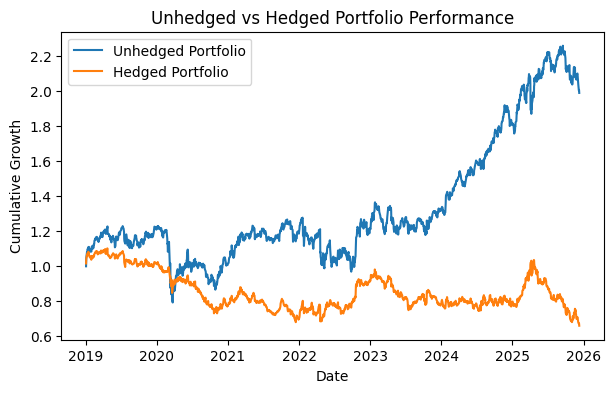

In [578]:
plt.figure(figsize=(7,4))

cum_unhedged = (1+combined['Portfolio']).cumprod()
cum_hedged   = (1+hedged_portfolio_returns).cumprod()

plt.plot(cum_unhedged, label='Unhedged Portfolio')
plt.plot(cum_hedged, label='Hedged Portfolio')
plt.title("Unhedged vs Hedged Portfolio Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth")
plt.legend()
plt.show()

#### Beta-Adjusted Portfolio Return Simulation

We simulate forward returns with
$R_{p,t} = \beta_{p}R_{m,t} + \epsilon-{t},$ where $\epsilon_t$ is idiosyncratic risk.

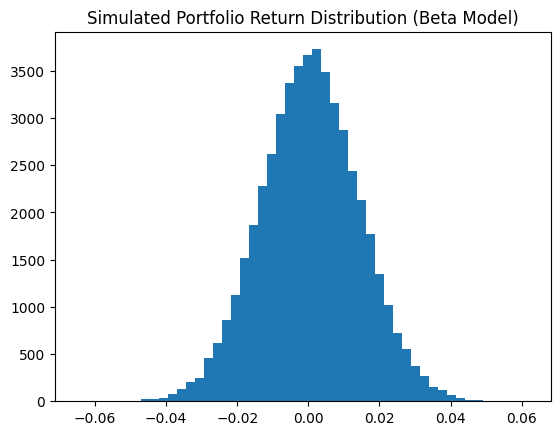

In [579]:
# regress portfolio returns on SPY to get residuals
model = sm.OLS(combined['Portfolio'], sm.add_constant(spy)).fit()
resid_std = model.resid.std()

sim_market = np.random.normal(spy.mean(), spy.std(), 50000)
sim_portfolio = portfolio_beta * sim_market + np.random.normal(0, resid_std, 50000)

plt.hist(sim_portfolio, bins=50)
plt.title("Simulated Portfolio Return Distribution (Beta Model)")
plt.show()

* Width consistent with our estimated beta and residual volatility.

**Final Thoughts**

- Before hedging, the optimal equity portfolio has a beta of approximately 0.76 w.r.t. SPY.  
- Using E-mini S&P 500 futures, we choose $\beta_{\text{target}} = -1$.  
- The beta hedging formula from [earlier](#hedging) yields a position of around **5.1 short ES contracts**, so the portfolio gains value when the index falls.  
- Running regression on returns on SPY, the $R^2$ drops from about *0.48 (unhedged)* to *0.04 (hedged)*. This shows us that most of the portfolio’s systematic market risk has been removed.  
- Under CAPM, the expected return shifts from about **+12.7% (unhedged)** to **–12.0% (hedged)**. This shows that a negative beta portfolio sacrifices long-run equity premium in exchange for protection.  
    - The [cumulative growth plot](#growth) supports this. Over a predominantly rising market, the unhedged portfolio trends up while the crash hedged portfolio underperforms because is designed to protect against large negative market moves.

## Sources

* Markowitz (1952), “Portfolio Selection,” Journal of Finance.
* Sharpe (1964), “Capital Asset Prices: A Theory of Market Equilibrium under Conditions of Risk,” Journal of Finance.
* Hull (2017), *Options, Futures, and Other Derivatives* (10th ed.).
* Ledoit & Wolf (2004), “Honey, I Shrunk the Sample Covariance Matrix,” available at http://www.ledoit.net/honey.pdf
* MathWorks (Value-at-Risk documentation): https://www.mathworks.com/help/risk/value-at-risk-estimation-and-backtesting.html
* Medium article on efficient frontier simulation (Python): 
https://medium.com/python-data/efficient-frontier-portfolio-optimization-with-python-part-2-2-2fe23413ad94
* QuantInsti blog – Asset beta and market beta in Python: 
https://blog.quantinsti.com/asset-beta-market-beta-python/
* Belasco (Montana State University) – Futures hedging lecture slides (Hull Ch.3 summary): 
https://www.montana.edu/ebelasco/agec421/hullslides/Ch03Hull.pdf

Thanks for reading!